<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Using-Logistic-Regression" data-toc-modified-id="Using-Logistic-Regression-1">Using Logistic Regression</a></span></li><li><span><a href="#Logistic-Regression-on-LeBron-Shots" data-toc-modified-id="Logistic-Regression-on-LeBron-Shots-2">Logistic Regression on LeBron Shots</a></span></li><li><span><a href="#Evaluating-the-Classifier" data-toc-modified-id="Evaluating-the-Classifier-3">Evaluating the Classifier</a></span></li><li><span><a href="#Multivariable-Logistic-Regression" data-toc-modified-id="Multivariable-Logistic-Regression-4">Multivariable Logistic Regression</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5">Summary</a></span></li></ul></div>

In [4]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [5]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [7]:
# HIDDEN
from scipy.optimize import minimize as sci_min
def minimize(cost_fn, grad_cost_fn, X, y, progress=True):
    '''
    Uses scipy.minimize to minimize cost_fn using a form of gradient descent.
    '''
    theta = np.zeros(X.shape[1])
    iters = 0
    
    def objective(theta):
        return cost_fn(theta, X, y)
    def gradient(theta):
        return grad_cost_fn(theta, X, y)
    def print_theta(theta):
        nonlocal iters
        if progress and iters % progress == 0:
            print(f'theta: {theta} | cost: {cost_fn(theta, X, y):.2f}')
        iters += 1
        
    print_theta(theta)
    return sci_min(
        objective, theta, method='BFGS', jac=gradient, callback=print_theta,
        tol=1e-7
    ).x

## Using Logistic Regression

We have developed all the components of logistic regression. First, the logistic model used to predict probabilities:

$$
\begin{aligned}
f_\hat{\theta} (x) = \sigma(\hat{\theta} \cdot x)
\end{aligned}
$$

Then, the cross entropy cost function:

$$
\begin{aligned}
L(\hat{\theta}, X, y) = &= \frac{1}{n} \sum_i \left(- y_i \ln \sigma_i - (1 - y_i) \ln (1 - \sigma_i ) \right) \\
\end{aligned}
$$

Finally, the gradient of the cross entropy cost for gradient descent:

$$
\begin{aligned}
\nabla_{\hat{\theta}} L(\hat{\theta}, X, y)
&= - \frac{1}{n} \sum_i \left(
    y_i - \sigma_i
\right) X_i \\
\end{aligned}
$$

In the expressions above, we let $ X $ represent the $ n \times p $ input data matrix, $ y $ the vector of observed data values, and $ f_\hat{\theta}(x) $ the logistic model. As a shorthand, we define $ \sigma_i = f_\hat{\theta}(X_i) = \sigma(X_i \cdot \hat \theta) $.

## Logistic Regression on LeBron Shots

Let us now return to the problem we faced at the start of this chapter: predicting which shots LeBron James will make. We start by loading the dataset of shots taken by LeBron in the 2017 NBA Playoffs.

In [3]:
lebron = pd.read_csv('lebron.csv')
lebron

,game_date,minute,opponent,action_type,shot_type,shot_distance,shot_made
0,20170415,10,IND,Driving Layup Shot,2PT Field Goal,0,0
1,20170415,11,IND,Driving Layup Shot,2PT Field Goal,0,1
2,20170415,14,IND,Layup Shot,2PT Field Goal,0,1
...,...,...,...,...,...,...,...
381,20170612,46,GSW,Driving Layup Shot,2PT Field Goal,1,1
382,20170612,47,GSW,Turnaround Fadeaway shot,2PT Field Goal,14,0
383,20170612,48,GSW,Driving Layup Shot,2PT Field Goal,2,1


We've included a widget below to allow you to pan through the entire DataFrame.

In [8]:
df_interact(lebron)

interactive(children=(IntSlider(value=0, description='row', max=377, step=7), Output()), _dom_classes=('widget-interact',))

(384 rows, 7 columns) total


We start by using using only the shot distance to predict the shot make or miss. `scikit-learn` conveniently provides a logistic regression classifier as the [`sklearn.linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class. To use the class, we first create our data matrix `X` and vector of observed outcomes `y`.

In [15]:
X = lebron[['shot_distance']].as_matrix()
y = lebron['shot_made'].as_matrix()
print('X:')
print(X)
print()
print('y:')
print(y)

X:
[[ 0]
 [ 0]
 [ 0]
 ...
 [ 1]
 [14]
 [ 2]]

y:
[0 1 1 ... 1 0 1]


As is customary, we split our data into a training set and a test set.

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=40, random_state=42
)
print(f'Training set size: {len(y_train)}')
print(f'Test set size: {len(y_test)}')

Training set size: 344
Test set size: 40


`scikit-learn` makes it simple to initialize the classifier and fit it on `X_train` and `y_train`:

In [38]:
from sklearn.linear_model import LogisticRegression
simple_clf = LogisticRegression()
simple_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

To visualize the classifier's performance, we plot the original points and the classifier's predicted probabilities.

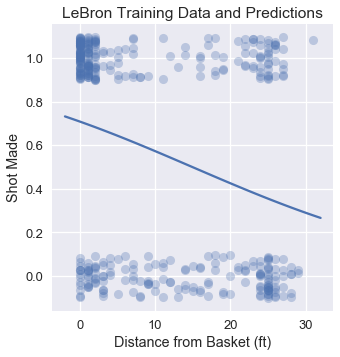

In [39]:
# HIDDEN 
np.random.seed(42)
sns.lmplot(x='shot_distance', y='shot_made',
           data=lebron,
           fit_reg=False, ci=False,
           y_jitter=0.1,
           scatter_kws={'alpha': 0.3})

xs = np.linspace(-2, 32, 100)
ys = simple_clf.predict_proba(xs.reshape(-1, 1))[:, 1]
plt.plot(xs, ys)

plt.title('LeBron Training Data and Predictions')
plt.xlabel('Distance from Basket (ft)')
plt.ylabel('Shot Made');

## Evaluating the Classifier

One method to evaluate the effectiveness of our classifier is to check its prediction accuracy: what proportion of points does it predict correctly?

In [40]:
simple_clf.score(X_test, y_test)

0.6

Our classifier achieves a rather low accuracy of 0.60 on the test set. If our classifier simply guessed each point at random, we would expect an accuracy of 0.50. In fact, if our classifier simply predicted that every shot LeBron takes will go in, we would also get an accuracy of 0.60:

In [46]:
# Calculates the accuracy if we always predict 1
np.count_nonzero(y_test == 1) / len(y_test)

0.6

For this classifier we only used one out of several possible features. As in multivariable linear regression, we will likely achieve a more accurate classifier by incorporating more features.

## Multivariable Logistic Regression

Incorporating more numerical features in our classifier is as simple as extracting additional columns from the `lebron` DataFrame into the `X` matrix. Incorporating categorical features, on the other hand, requires us to apply a one-hot encoding. In the code below, we augment our classifier with the `minute`, `opponent`, `action_type`, and `shot_type` features, using the `DictVectorizer` class from `scikit-learn` to apply a one-hot encoding to the categorical variables.

In [50]:
from sklearn.feature_extraction import DictVectorizer

columns = ['shot_distance', 'minute', 'action_type', 'shot_type', 'opponent']
rows = lebron[columns].to_dict(orient='row')

onehot = DictVectorizer(sparse=False).fit(rows)
X = onehot.transform(rows)
y = lebron['shot_made'].as_matrix()

X.shape

(384, 42)

We will again split the data into a training set and test set:

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=40, random_state=42
)
print(f'Training set size: {len(y_train)}')
print(f'Test set size: {len(y_test)}')

Training set size: 344
Test set size: 40


Finally, we fit our model once more and check its accuracy:

In [68]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
print(f'Test set accuracy: {clf.score(X_test, y_test)}')

Test set accuracy: 0.725


This classifier is around 12% more accurate than the classifier that only took the shot distance into account.

## Summary

We have developed the mathematical and computational machinery needed to use logistic regression for classification. Logistic regression is widely used for its simplicity and effectiveness in prediction.